In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import gspread
import matplotlib.pyplot as plt

In [2]:
exps = ['0925_jiuhai_seed-0', '0926_jiuhai_seed-1']

datasets = ['ogb-molpcba', 'ogb-molhiv', 'ogbg-ppa', 'UPFD', 'SBM-Isolation', 'SBM-Environment', 'RotatedMNIST', 'ColoredMNIST']
algorithms = ['ERM', 'groupDRO', 'IRM', 'deepCORAL', 'DANN', 'DANN-G', 'MLDG', 'FLAG']
models = ['gin', 'mlp', 'gin_15_layers', 'gcn', 'gin_virtual', 'transformer', 'cheb', '3wlgnn']

num_epoches = {
    'ogb-molpcba': 200,
    'ogb-molhiv': 200, 
    'ogbg-ppa': 200,
    'UPFD': 200,
    'SBM-Isolation': 200,
    'SBM-Environment': 200,
    'RotatedMNIST': 200,
    'ColoredMNIST': 200,
}


def parse_performance(d, a, m, exps, assert_length=True):
    epoches_coeff = 1
    performances = []
    if d in ['UPFD', 'SBM-Environment']:
        exps = [exps[-1]]
    if m in ['3wlgnn']:
        exps = [exps[-1]]
        epoches_coeff = 1
    for exp in exps:
        seed = int(exp[-1])
        test_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_test_eval.csv', sep=',')
        test_eval = test_eval.dropna(axis=0)
        test_eval = test_eval.iloc[:,1].to_numpy()
        val_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_val_eval.csv', sep=',')
        val_eval = val_eval.dropna(axis=0)
        val_eval = val_eval.iloc[:,1].to_numpy()
        train_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_train_eval.csv', sep=',')
        train_eval = train_eval.dropna(axis=0)
        train_eval = train_eval.iloc[:,1].to_numpy()
        nepoch = int(num_epoches[d] * epoches_coeff)
        if len(test_eval) < nepoch:
            raise ValueError
        performances.append((train_eval[:nepoch], val_eval[:nepoch], test_eval[:nepoch]))
    return performances
    
def filter_test_performance(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(test_eval[np.argmax(val_eval)])
    return results


def filter_performance_gaps(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append((train_eval[np.argmax(val_eval)]-test_eval[np.argmax(val_eval)]))
    return results

    
def filter_uncertainty(results):
    results = np.array(results)
    if len(results) == 1:
        return f'{results[0]:.3f}±?'
    return f'{np.mean(results):.3f}±{np.std(results):.3f}'


def filter_plot(performances):
    results = []
    assert len(performances) == 1
    for per in performances:
        train_eval, val_eval, test_eval = per
        plt.figure(figsize=(10, 5))
        plt.plot(train_eval, 'r')
        plt.plot(val_eval, 'g')
        plt.plot(test_eval, 'b')
        plt.show()
    return results


def parse(mode, **kwargs):
    try:
        if mode == 'test_performance':
            return filter_uncertainty(filter_test_performance(parse_performance(**kwargs)))
        if mode == 'performance_gap':
            return filter_uncertainty(filter_performance_gaps(parse_performance(**kwargs)))
        if mode == 'convergence_plot':
            return filter_plot(parse_performance(**kwargs))
        else:
            raise NotImplementError
    except ValueError as e:
        return 'nf'
    except OSError as e:
        return 'fnf'
    except pd.errors.EmptyDataError as e:
        return 'err'

In [3]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('test_performance', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table.to_csv(index=False, header=False))

0.164±0.010,0.158±0.010,0.064±0.010,0.094±0.003,fnf,fnf,nf,0.174±0.006
0.726±0.025,0.732±0.011,0.701±0.012,0.740±0.013,fnf,fnf,nf,0.776±0.001
0.596±0.003,0.565±0.007,0.328±0.006,0.600±0.007,fnf,fnf,0.102±0.004,0.608±0.026
0.637±?,0.630±?,0.638±?,0.634±?,0.632±?,0.632±?,0.627±?,0.637±?
0.624±0.002,0.627±0.003,0.629±0.002,0.627±0.000,0.611±0.005,0.616±0.006,0.633±0.006,0.627±0.005
0.759±?,0.767±?,0.767±?,0.773±?,0.762±?,0.759±?,nf,nf
0.518±0.002,0.507±0.003,0.519±0.001,0.511±0.003,0.514±0.000,0.491±0.003,0.515±0.002,0.510±0.005
0.106±0.001,0.105±0.000,0.105±0.000,0.106±0.001,fnf,fnf,0.105±0.000,0.105±0.000



In [4]:
table = []
a = algorithms[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, m in enumerate(models):
        table_dataset.append(parse('test_performance', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=models)

print(table.to_csv(index=False, header=False))

0.164±0.010,0.103±0.002,0.145±0.012,0.168±0.007,0.173±0.013,fnf,nf,nf
0.726±0.025,0.690±0.006,0.694±0.023,0.750±0.001,0.775±0.018,fnf,0.757±0.007,nf
0.596±0.003,0.099±0.005,nf,0.576±0.005,nf,fnf,nf,nf
0.637±?,0.490±?,0.639±?,0.624±?,0.526±?,fnf,0.825±?,nf
0.624±0.002,0.260±0.003,0.664±0.022,0.547±0.015,0.704±0.004,fnf,0.717±0.008,nf
0.759±?,0.335±?,0.867±?,0.693±?,0.859±?,fnf,0.794±?,nf
0.518±0.002,0.328±0.005,0.492±0.002,0.437±0.000,0.538±0.003,fnf,0.555±0.001,nf
0.106±0.001,0.105±0.000,0.105±0.000,0.105±0.000,0.105±0.000,fnf,0.105±0.000,nf



In [5]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('performance_gap', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table.to_csv(index=False, header=False))

0.174±0.026,0.175±0.024,-0.007±0.008,-0.004±0.008,fnf,fnf,nf,0.173±0.112
0.111±0.019,0.148±0.081,-0.008±0.035,-0.007±0.005,fnf,fnf,nf,0.189±0.026
0.289±0.031,0.351±0.033,-0.005±0.046,0.225±0.007,fnf,fnf,0.022±0.004,0.339±0.019
0.226±?,0.230±?,0.203±?,0.189±?,0.061±?,0.213±?,0.137±?,0.219±?
0.067±0.021,0.049±0.004,0.050±0.005,0.071±0.002,0.051±0.005,0.040±0.005,0.056±0.002,0.062±0.003
0.057±?,0.046±?,0.054±?,0.056±?,0.048±?,0.049±?,nf,nf
0.094±0.021,0.135±0.010,0.111±0.006,0.124±0.010,0.093±0.007,0.089±0.005,0.078±0.020,0.121±0.020
0.743±0.002,0.743±0.001,0.747±0.001,0.742±0.002,fnf,fnf,0.745±0.000,0.744±0.001



In [6]:
table = []
a = algorithms[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, m in enumerate(models):
        table_dataset.append(parse('performance_gap', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=models)

print(table.to_csv(index=False, header=False))

0.174±0.026,-0.017±0.006,0.074±0.003,0.163±0.061,0.364±0.010,fnf,nf,nf
0.111±0.019,0.024±0.002,0.169±0.058,0.147±0.016,0.171±0.001,fnf,0.133±0.061,nf
0.289±0.031,0.005±0.003,nf,0.374±0.005,nf,fnf,nf,nf
0.226±?,0.015±?,0.216±?,0.005±?,0.333±?,fnf,0.070±?,nf
0.067±0.021,-0.002±0.004,0.015±0.004,0.190±0.024,0.041±0.001,fnf,0.036±0.023,nf
0.057±?,0.003±?,0.031±?,0.036±?,0.041±?,fnf,0.039±?,nf
0.094±0.021,-0.026±0.015,0.121±0.004,-0.010±0.003,0.149±0.016,fnf,0.090±0.001,nf
0.743±0.002,0.744±0.001,0.743±0.001,0.745±0.000,0.744±0.000,fnf,0.744±0.000,nf



Algorithm: ERM, Model: gin
Dataset: ogb-molpcba


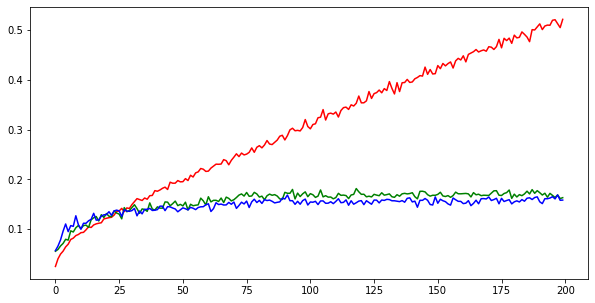

Dataset: ogb-molhiv


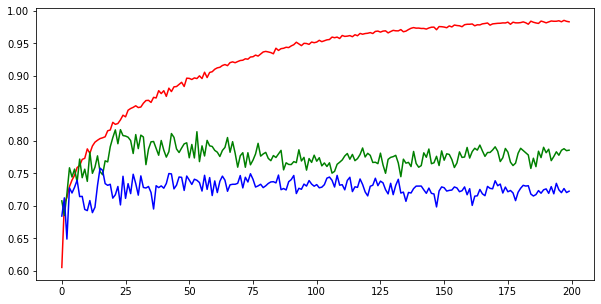

Dataset: ogbg-ppa


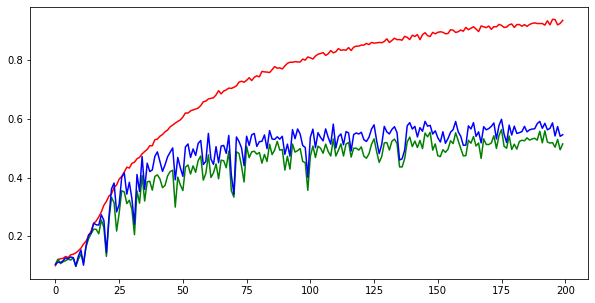

Dataset: UPFD


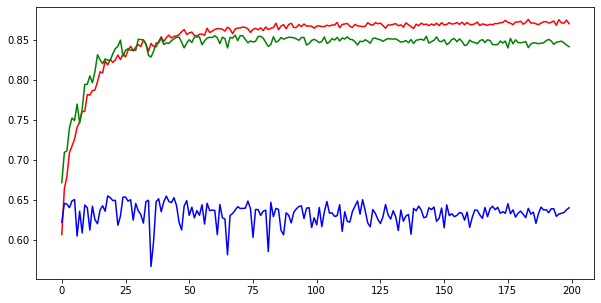

Dataset: SBM-Isolation


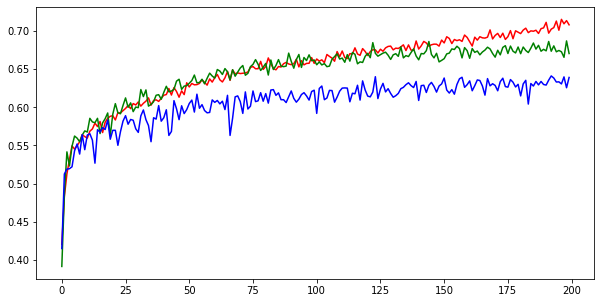

Dataset: SBM-Environment


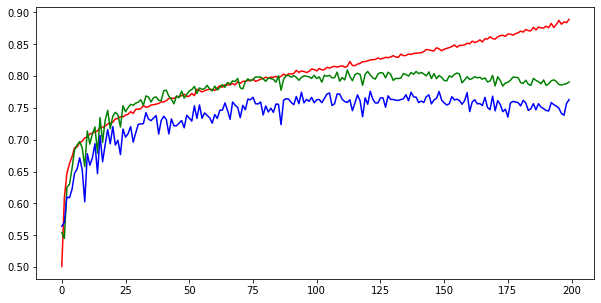

Dataset: RotatedMNIST


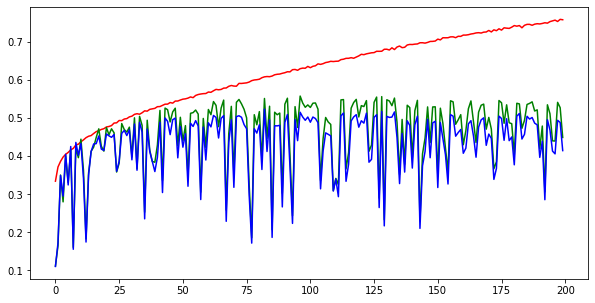

Dataset: ColoredMNIST


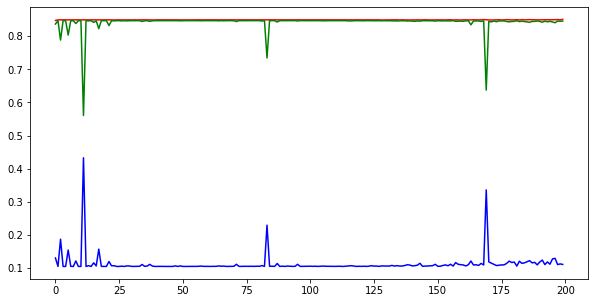

In [7]:
a = algorithms[0]
m = models[0]
exps = [exps[-1]]

print(f'Algorithm: {a}, Model: {m}')
for i, d in enumerate(datasets):
    print(f'Dataset: {d}')
    parse('convergence_plot', d=d, a=a, m=m, exps=exps)

Algorithm: DANN, Model: gin
Dataset: ogb-molpcba
Dataset: ogb-molhiv
Dataset: ogbg-ppa
Dataset: UPFD


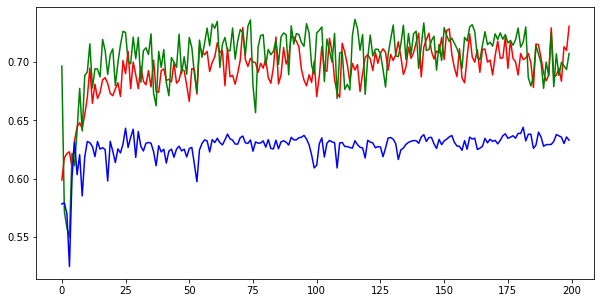

Dataset: SBM-Isolation


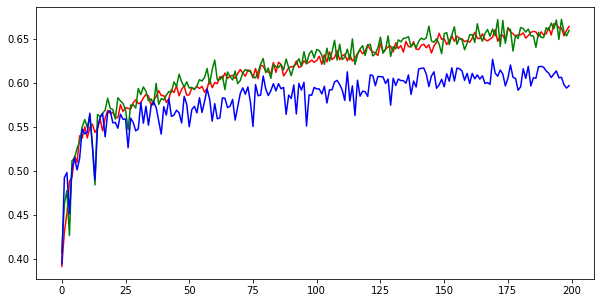

Dataset: SBM-Environment


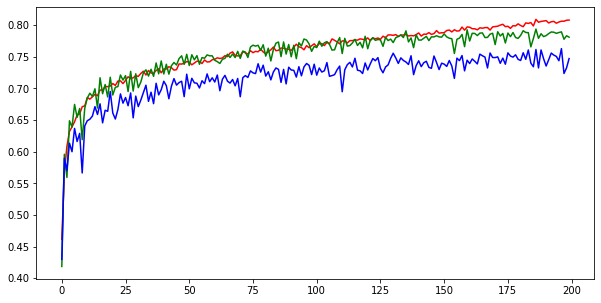

Dataset: RotatedMNIST


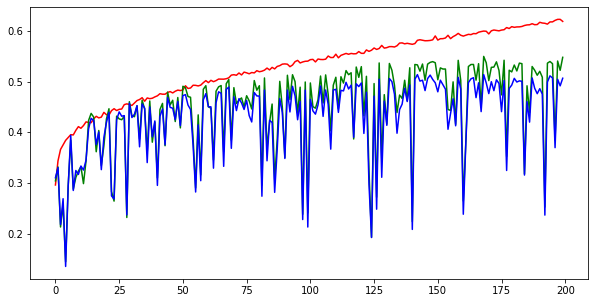

Dataset: ColoredMNIST


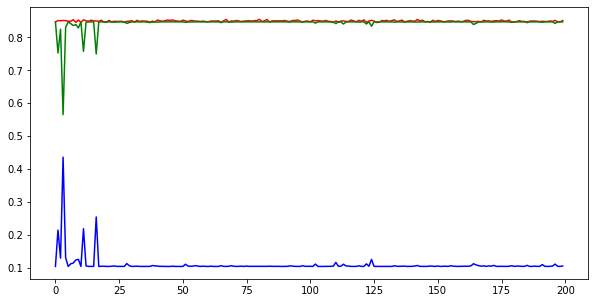

In [10]:
a = algorithms[4]
m = models[0]
exps = [exps[-1]]

print(f'Algorithm: {a}, Model: {m}')
for i, d in enumerate(datasets):
    print(f'Dataset: {d}')
    parse('convergence_plot', d=d, a=a, m=m, exps=exps)

Algorithm: ERM, Model: cheb
Dataset: ogb-molpcba
Dataset: ogb-molhiv


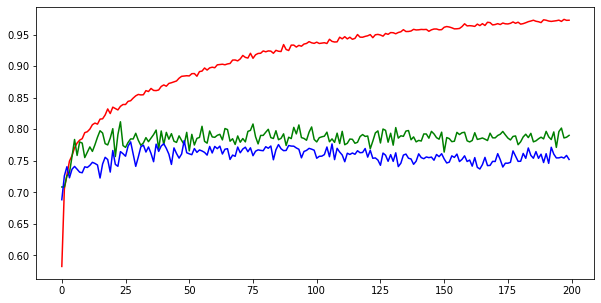

Dataset: ogbg-ppa
Dataset: UPFD


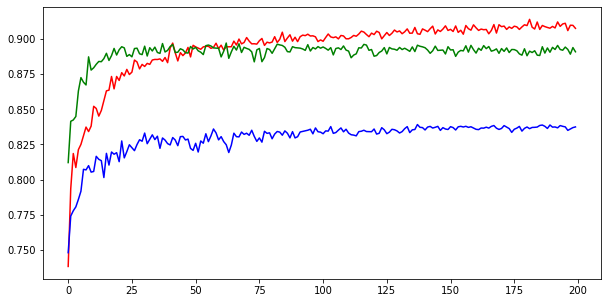

Dataset: SBM-Isolation


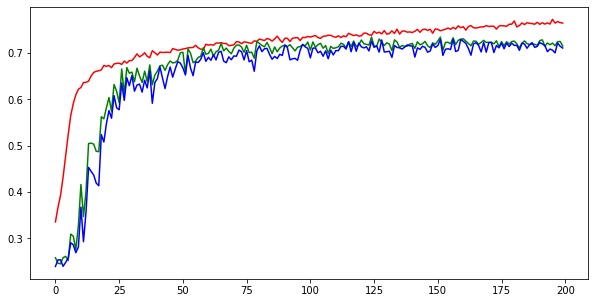

Dataset: SBM-Environment


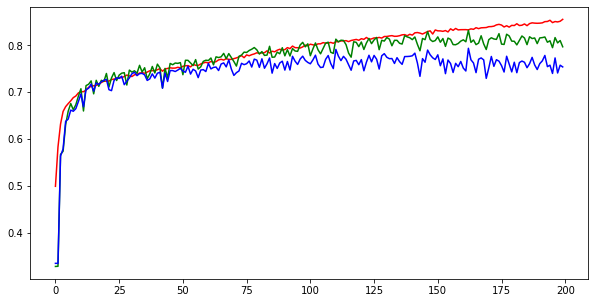

Dataset: RotatedMNIST


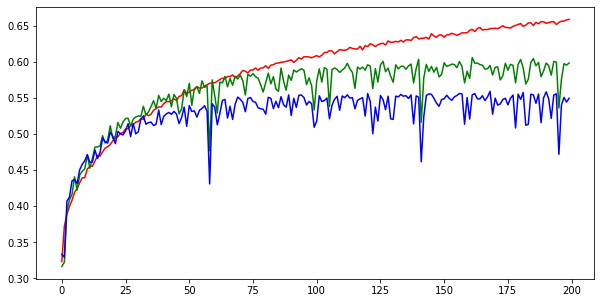

Dataset: ColoredMNIST


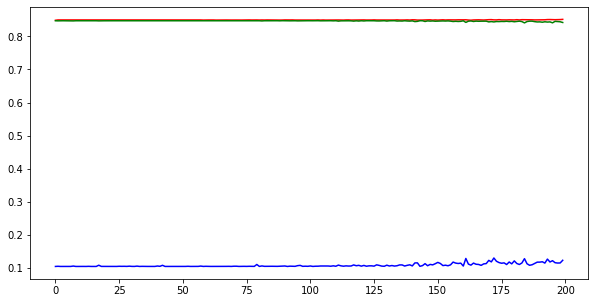

In [9]:
a = algorithms[0]
m = models[-2]
exps = [exps[-1]]

print(f'Algorithm: {a}, Model: {m}')
for i, d in enumerate(datasets):
    print(f'Dataset: {d}')
    parse('convergence_plot', d=d, a=a, m=m, exps=exps)